<a href="https://colab.research.google.com/github/garrett-vangilder/CS5262/blob/main/fema_declarations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Type of Disasters by Heuristics

## Background

Extreme weather events are becoming more likely as the effects of climate change are realized. This can be seen in the plethora of wildfires throughout the West. The Federal Emergency Management Agency (FEMA) does not declare every extreme weather event a disaster, but through a workflow specified by the Stafford Act, state and federal leaders can work together to determine if federal aid is necessary. The type of aid given to individuals is broad. It can include financial gifts to individuals or small businesses with the intention of using the funds for temporary housing or repairs.

Is it possible to use [heuristics gathered by FEMA](https://www.kaggle.com/datasets/headsortails/us-natural-disaster-declarations) to determine the type of incident?

## Project Description

Using historical FEMA disaster records, researchers may determine the disaster types when given a date and a state location. This could be useful in analyzing changes to local and federal funding for extreme weather events since different disasters require different types of services. This research can potentially be used as a proxy for defining the financial repercussions of climate change. When paired with a municipalities budget and other financial records, this data could help decide if funds are over or under-provisioned for disaster relief. Federal governments could extrapolate this data to inform federal funding better. There may even be a case for private real estate development firms to use this model when selecting the viability of significant projects for a given location due to changing weather patterns.

The overall goal of this model is to be used as an severe weather predictor by disaster type for states and seasons.

## Performance Metrics

We will analyze the performance of this classification model through the receiver operating characteristics curve. This model will be considered a success if the classification is greater than 50% for test cases.

## Exploratory Data Analysis

Through my initial exploratory data analysis, I am looking to answer the following questions to understand my dataset better.

1. Are all states represented, and if so which state is most prone to disasters?

2. Are disasters becoming more or less common? How many disasters are there each year?

3. What are the most common disaster types?

4. Are there any correlated variables in my dataset? 

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

#### Load Data

We will injest our dataset, and the data dictionary.

Data was initially sourced from FEMA, however it has been made public via [kaggle](https://www.kaggle.com/datasets/headsortails/us-natural-disaster-declarations)

We wil source our data from a clone located in the corresponding [github repo](https://github.com/garrett-vangilder/CS5262).

In [141]:
data_dictionary = pd.read_csv('https://raw.githubusercontent.com/garrett-vangilder/CS5262/main/data_dictionary.csv')

disasters = pd.read_csv('https://raw.githubusercontent.com/garrett-vangilder/CS5262/main/us_disaster_declarations.csv')


#### Data Dictionary

In [142]:
display(data_dictionary)

,feature,description,type
0,fema_declaration_string,codified identifier for disaster - declaration...,string
1,disaster_number,an incremented value used to designate an event,integer
2,state,US state or territory - formatted as XX,string
3,declaration_type,"DR(""major disaster"") or EM(""emergency manageme...",string
4,declaration_date,date of disaster declaration formatted YYYY-MM...,datetime
5,fy_declared,fiscal year of declaration formatted YYYY,integer
6,incident_type,"classification of incident type example: ""Floo...",integer
7,declaration_title,generic identifier for incident typically huma...,string
8,ih_program_declared,"boolean value denotes if the ""Individual and H...",boolean
9,ia_program_declared,"boolean value denotes if the ""Individual Assis...",boolean


#### 1. Are all states represented, and if so which state is most prone to disasters?

In [143]:
disasters.groupby('state').fema_declaration_string.nunique().sort_values(ascending=False)


state
TX    371
CA    357
OK    218
WA    191
FL    168
OR    140
NM    111
NY    107
AZ    106
LA    101
CO    101
NV    100
AL     99
MT     98
MS     90
SD     87
KY     86
TN     83
KS     82
AR     79
MO     77
MN     77
AK     77
NE     76
WV     75
NC     73
IA     73
GA     72
VA     72
ND     67
IL     64
PA     63
ME     63
HI     61
OH     59
NJ     57
NH     57
MA     56
WI     54
ID     53
VT     52
UT     51
IN     51
PR     46
MI     43
CT     39
SC     38
WY     38
MD     37
VI     30
RI     27
DE     25
DC     23
MP     23
FM     21
GU     19
AS     16
MH      7
PW      1
Name: fema_declaration_string, dtype: int64

In [144]:
len(disasters.groupby('state'))

59

All states are represented in the dataset, however it seems that there are multiple rows per unique incident, moving forward all queries will filter data for unique entries by FEMA declaration string.

#### 2. Are disasters becoming more or less common? How many disasters are there each year?

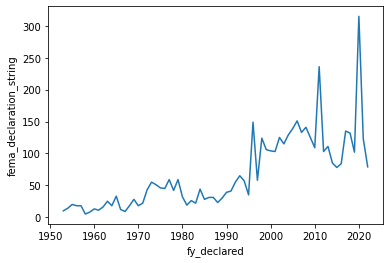

In [145]:
disaster_count_by_year = disasters.groupby('fy_declared').fema_declaration_string.nunique().sort_index()
sns.lineplot(data=disaster_count_by_year);

In [146]:
disaster_count_by_year.mean()

66.97142857142858

It seems that there are generally more FEMA incidents in the recent future compared to past events. 

#### 3. What are the most common disaster types?


In [147]:
disasters.groupby('incident_type').fema_declaration_string.nunique().sort_values(ascending=False)

incident_type
Fire                1542
Severe Storm(s)     1017
Flood                853
Hurricane            425
Tornado              177
Snow                 169
Biological           167
Severe Ice Storm      74
Typhoon               58
Drought               46
Earthquake            35
Other                 31
Coastal Storm         31
Freezing              18
Mud/Landslide          9
Toxic Substances       8
Fishing Losses         6
Dam/Levee Break        6
Volcano                6
Human Cause            4
Tsunami                3
Terrorist              2
Chemical               1
Name: fema_declaration_string, dtype: int64

Natural disasters seem to be the most common disaster, however it is interesting to note that there are chemical, terrorist, and generally human-centric disasters that do qualify for FEMA assistance. 

#### 4. Are there any correlated variables in my dataset?

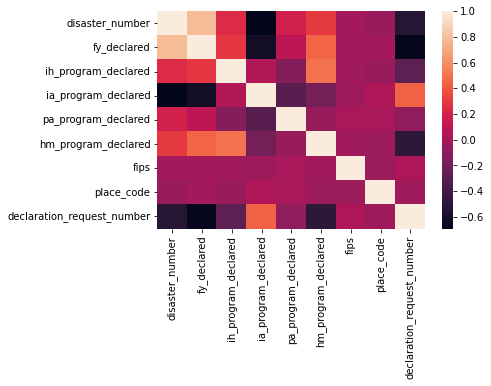

In [148]:
sns.heatmap(disasters.corr())

`disaster_number` and `fy_declaraed` correspond, this is not a surprise since `disaster_number` increments, as do years. 

## Feature engineering

Due to the nature of our dataset, we will need to perform some transformations to better train our model. We are interested in disasters that are weather related, meaning we will also need to perform some operations to clean or remove rows from our dataset. 

We will remove rows with the following `incident_type`
1. Biological
2. Toxic Substance
3. Human Cause
4. Terrorist
5. Chemical

We will maintain `Fishing Losses` and `Dam/Levee Break` since they theoretically could be caused by extreme weather patterns. Human cause via climate migration is also outside the scope of this model. 

Disasters that persist over a larger time period are over valued in this model, we are not looking into the length of a model but instead we are interested in unique events. Because of this we will enforce a uniqueness to `fema_declaration_string` meaning that only the initial row for a declaration string will be used. 

`season` will be added - this will be specific to the `incident_begin_date` and for simplicities will be specific to a given subset of months

- Winter: Dec, Jan, Feb
- Spring: Mar, Apr, May
- Summer: Jun, Jul, Aug
- Fall: Sept, Oct, Nov


In [149]:
# Drop non weather specific events
it_to_drop = ['Biological', 'Toxic Substance', 'Human Cause', 'Terrorist', 'Chemical']

disasters = disasters[~disasters.incident_type.isin(it_to_drop)]


In [150]:
# Drop all but first entry by fema_declaration_string
disasters = disasters.drop_duplicates(subset=['fema_declaration_string'])

In [151]:
# Add seasons
WINTER = 'winter'
SPRING = 'spring'
SUMMER = 'summer'
FALL = 'fall'

month_to_seasons = {
    1: WINTER,
    2: WINTER,
    3: SPRING,
    4: SPRING,
    5: SPRING,
    6: SUMMER,
    7: SUMMER,
    8: SUMMER,
    9: FALL,
    10: FALL,
    11: FALL,
    12: WINTER
}
disasters['declaration_date'] = pd.to_datetime(disasters.declaration_date, format='%Y-%m-%d %H:%M:%S')
disasters['month'] = disasters['declaration_date'].dt.month
disasters['season'] = disasters.month.apply(lambda month: month_to_seasons.get(month))

In [152]:
# Drop unrelated columns

disasters = disasters.drop(
    columns=['designated_area', 'declaration_date', 'fema_declaration_string', 'ih_program_declared','ia_program_declared',
             'pa_program_declared','hm_program_declared', 
             'last_ia_filing_date', 'hash', 'id', 'last_refresh',
             'declaration_title', 'incident_begin_date', 'incident_end_date', 'disaster_closeout_date']
)

In [153]:
# Drop Regions with low incident count

regions_to_grou = ['MP', 'FM', 'GU', 'AS', 'MH', 'PW']
disasters['state'] = disasters.state.apply(lambda state: 'Other' if state in regions_to_drop else state)


In [154]:
# Group incident types with few examples (<10)
it_to_group = ['Mud/Landslide', 'Toxic Substances', 'Fishing Losses', 'Dam/Levee Break', 'Volcano', 'Tsunami']

disasters['incident_type'] = disasters.incident_type.apply(lambda incident_type: 'Other' if incident_type in it_to_group else incident_type)


## Train test split

based on the metadata (such as size
and target class distribution) of your dataset, briefly outline your train/test percent split. Include the percentage for your golden holdout set if you plan to leave one out

In [155]:
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification

In [156]:
class_column = 'incident_type'

X = disasters.drop(columns=class_column)
Y = disasters[class_column]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=5, stratify=Y)

## Establish an initial pipeline

briefly describe the
pipes you may need

In [157]:
from sklearn import config_context
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler

In [158]:
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder())])

num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean')),
                               ('scale_num', StandardScaler())])

In [ ]:
cat_cols = ['state', 'declaration_type', 'season', 'month']

num_cols = ['fy_declared', 'disaster_number', 'fips', 'place_code', 'declaration_request_number']

preproc = ColumnTransformer(
    [
        ('cat_pipe', cat_pipeline, cat_cols),
        ('num_pipe', num_pipeline, num_cols)
    ],
                             remainder='passthrough')

In [159]:
log_pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01, l1_ratio=1))])

rf_pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', RandomForestClassifier())])

gb_pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0))])

with config_context(display='diagram'):
    display(log_pipe)
    display(rf_pipe)
    display(gb_pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  ['state', 'declaration_type',
                                                   'season', 'month']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  ['fy_declared',
                                                   'disaster_number', 'fips',
                                                   'place_code',
                                                   'declaration_request_number'])])),
                ('mdl',
                 LogisticRegression(l1_ratio=1, penalty='elasticnet',
                                    solver='saga', tol=0.01))])

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  ['state', 'declaration_type',
                                                   'season', 'month']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  ['fy_declared',
                                                   'disaster_number', 'fips',
                                                   'place_code',
                                                   'declaration_request_number'])])),
                ('mdl', RandomForestClassifier())])

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  ['state', 'declaration_type',
                                                   'season', 'month']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  ['fy_declared',
                                                   'disaster_number', 'fips',
                                                   'place_code',
                                                   'declaration_request_number'])])),
                ('mdl',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=0))])

### Cross-validation / Hyperparameter tuning

We will tune our models, for our Logistic regression, Gradient Boosting, and Random Forest models, we will opt for sensible configuration implemented by scikit.

In [160]:
log_gs = GridSearchCV(log_pipe, param_grid={}, return_train_score=True)
rf_gs = GridSearchCV(rf_pipe, param_grid={}, return_train_score=True)
gb_gs = GridSearchCV(gb_pipe, param_grid={}, return_train_score=True)

## Model fitting and evaluation

list 1-3 assumptions you have about feature importance or how you anticipate your model’s performance will be

In [161]:
log_gs.fit(X_train, y_train)
rf_gs.fit(X_train, y_train)
gb_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder())]),
                                                                         ['state',
                                                                          'declaration_type',
                                                                          'season',
                                                                      

In [162]:
print('LogisticRegression Model:')
print(log_gs.best_score_)
log_gs.best_params_
pd.DataFrame(log_gs.cv_results_)

print('RandomForest Model:')
print(rf_gs.best_score_)
rf_gs.best_params_
pd.DataFrame(rf_gs.cv_results_)

print('GradientBoosting Model:')
print(gb_gs.best_score_)
gb_gs.best_params_
pd.DataFrame(gb_gs.cv_results_)

LogisticRegression Model:
0.7379615952732644
RandomForest Model:
0.7500738552437223
GradientBoosting Model:
0.49985228951255534


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.237681,0.074721,0.015894,0.00156,{},0.035451,0.602659,0.61743,0.608567,0.635155,0.499852,0.23246,1,0.04579,0.625923,0.619276,0.642171,0.658789,0.51839,0.236696


In [163]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [164]:
print(classification_report(y_test, log_gs.best_estimator_.predict(X_test)))

print(classification_report(y_test, rf_gs.best_estimator_.predict(X_test)))

print(classification_report(y_test, gb_gs.best_estimator_.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

   Coastal Storm       0.00      0.00      0.00         8
         Drought       0.42      0.42      0.42        12
      Earthquake       0.00      0.00      0.00         9
            Fire       0.98      0.94      0.96       386
           Flood       0.62      0.66      0.64       213
        Freezing       0.00      0.00      0.00         4
       Hurricane       0.66      0.79      0.72       106
           Other       0.00      0.00      0.00        17
Severe Ice Storm       0.40      0.11      0.17        19
 Severe Storm(s)       0.65      0.80      0.72       254
            Snow       0.66      0.60      0.62        42
         Tornado       0.50      0.18      0.27        44
         Typhoon       0.65      1.00      0.79        15

        accuracy                           0.75      1129
       macro avg       0.43      0.42      0.41      1129
    weighted avg       0.73      0.75      0.73      1129

           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

LogisticRegression Model:


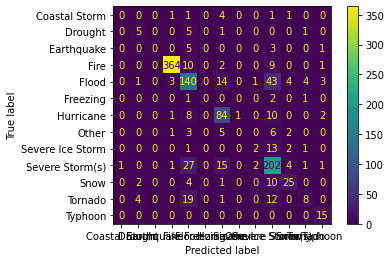

RandomForest Model:


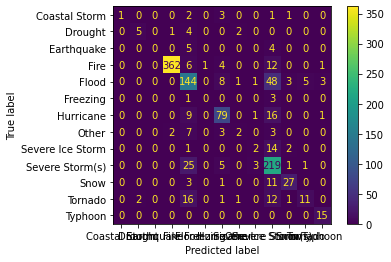

Gradient Boosting Model:


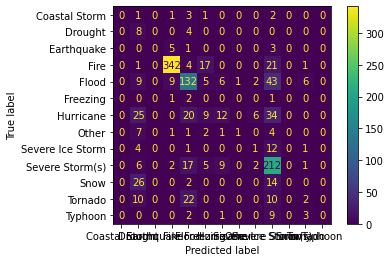

In [167]:
print('LogisticRegression Model:')
cm = confusion_matrix(y_test, log_gs.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_gs.classes_)
disp.plot()

plt.show()

print('RandomForest Model:')
cm = confusion_matrix(y_test, rf_gs.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_gs.classes_)
disp.plot()

plt.show()

print('Gradient Boosting Model:')
cm = confusion_matrix(y_test, gb_gs.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_gs.classes_)
disp.plot()

plt.show()